## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for alpha / beta (intercept / slope) linear fit to general market movement

In [1]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [52]:
## API Library Setup
import os

## Robinhood API Setup
import robin_stocks as rs
# Connecting to RobinHood
rs.login(
    username = os.getenv("RH_LOGIN"),
    password = os.getenv("RH_PASS"),
    expiresIn = 3600*8,
    by_sms = False
)

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')

ERROR: There was an issue loading pickle file. Authentication may be expired - logging in normally.


In [3]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
max_investment = 1180*0.2
min_investment = 15

In [4]:
%matplotlib inline
## Installing Required Packages
import sys
import time
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy import stats

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


In [5]:
## Checking Current Stock Holdings
my_stocks = rs.build_holdings()
Holding_Summary = pd.DataFrame({key:value for key,value in my_stocks.items()})
print(Holding_Summary)

                                                    DGX  \
price                                        117.140000   
quantity                                     1.00000000   
average_buy_price                              116.6700   
equity                                           117.14   
percent_change                                     0.40   
equity_change                                  0.470000   
type                                              stock   
name                                  Quest Diagnostics   
id                 f003a8ab-aeac-4e3f-8357-215087838cff   
pe_ratio                                      21.207700   
percentage                                         5.69   

                                                    ABC  \
price                                         97.270000   
quantity                                     2.00000000   
average_buy_price                               96.1800   
equity                                           194.54

### Historical Data Pull

In [95]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume


Skipped AAPL No Data

Pulling Company Data



Formatting Final Dataset


### Exploring Total Market Performance

In [10]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()
Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(10)

,close,high,low,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,
2020-09-30 00:00:00-04:00,65.462945,66.519202,64.647180,3.381237e+06,1033.0,0.006021,0.033765,0.164597,64.713653,40.564562,-0.018915
2020-10-01 00:00:00-04:00,66.046620,66.892615,65.008300,3.344968e+06,1033.0,0.008916,0.042495,-0.010727,65.252107,40.130841,0.068200
2020-10-02 00:00:00-04:00,66.150740,66.991431,64.462660,3.112881e+06,1033.0,0.001576,0.029518,-0.069384,65.631443,42.559421,0.128039
2020-10-05 00:00:00-04:00,67.462264,67.943007,66.176532,2.904240e+06,1033.0,0.019826,0.031127,-0.067025,66.038740,36.703497,0.244406
2020-10-06 00:00:00-04:00,66.955520,68.763264,66.484274,3.340473e+06,1033.0,-0.007512,0.028959,0.150205,66.415618,42.409414,0.273509
2020-10-07 00:00:00-04:00,68.226293,68.897444,67.143682,2.925326e+06,1033.0,0.018979,0.042212,-0.124278,66.968287,45.725230,0.359205
2020-10-08 00:00:00-04:00,68.958954,69.608366,67.926421,3.081399e+06,1033.0,0.010739,0.044095,0.053352,67.550754,46.039305,0.440720
2020-10-09 00:00:00-04:00,69.410771,70.281966,68.616297,2.930597e+06,1032.0,0.006552,0.049282,-0.048940,68.202760,44.364907,0.496414
2020-10-12 00:00:00-04:00,69.723524,70.529634,68.870432,2.812884e+06,1033.0,0.004506,0.033519,-0.040167,68.655013,47.799822,0.522998


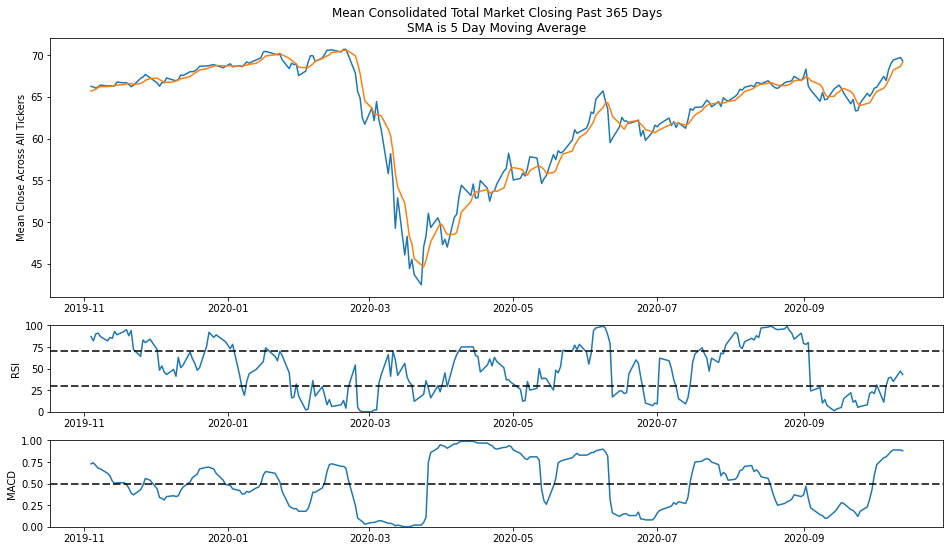

In [11]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [12]:
## Calculating Market Deciders
Market_Strength = np.mean(Total_Market.RSI.tail(5))/100
Market_Momentum = (np.mean(Plot_Data.MACD.tail(5))-np.min(Plot_Data.MACD.tail(5)))/(np.max(Plot_Data['MACD'].tail(5)) - np.min(Plot_Data['MACD'].tail(5)))
print("Market Strength :",np.round(Market_Strength,3),
      "\nMarket_Momentum :",np.round(Market_Momentum,3))

Max_Beta_P = np.round(1 - Market_Momentum,3)
Min_Beta = 1 if Market_Momentum > 0.50 else -2
Max_Alpha_P = np.round(Market_Momentum,3)
Min_Alpha = 0 if Market_Momentum <= 0.50 else -1

print("Beta Significance :",Max_Beta_P,
     "\nAlpha Significance :",Max_Alpha_P)

Market Strength : 0.408 
Market_Momentum : 0.68
Beta Significance : 0.32 
Alpha Significance : 0.68


## Digging Into A Sector Ranking

In [13]:
Sectors = list(Combined_Data['sector'].unique())
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    max_beta_p = Max_Beta_P,
                                    max_alpha_p = Max_Alpha_P,
                                    min_beta = Min_Beta,
                                    min_alpha = Min_Alpha,
                                    max_rsi = 70,
                                    min_risk_ratio = 1
)
Sector_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
sector,,,,,,,,,,,,,,
Healthcare,135,0.043183,83.309771,88.868797,80.530258,85.309493,1.212149,0.006210,55.703779,0.586700,-0.001475,0.610,1.233161,0.002
Consumer Cyclical,153,0.036142,61.928543,65.622198,60.081715,63.498518,1.059191,0.006122,49.967872,0.329178,-0.002477,0.496,1.199028,0.000


## Diving Further Into Individual Idustries

In [14]:
Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
Industries = list(Top_Sector['industry'].unique())
Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                      groups = Industries,
                                      column = 'industry',
                                      min_macd = 0,
                                      max_beta_p = Max_Beta_P,
                                      max_alpha_p = Max_Alpha_P,
                                      min_beta = Min_Beta,
                                      min_alpha = Min_Alpha,
                                      max_rsi = 70,
                                      min_risk_ratio = 1
                                     )
Industry_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
industry,,,,,,,,,,,,,,
Autos,22,0.055030,59.576382,63.084527,57.822310,60.919818,1.094140,0.007512,66.576691,0.682013,0.000542,0.450,1.259776,0.038
Manufacturing - Apparel & Furniture,19,0.046970,73.538963,78.704721,70.956084,75.563158,1.079422,0.006436,54.241023,0.408068,-0.001964,0.530,1.402468,0.002
Medical Devices,16,0.052254,116.462369,126.532006,111.427550,119.928925,1.450424,0.005183,59.957754,0.713149,-0.002419,0.654,1.593349,0.002
Biotechnology,45,0.042556,69.742659,74.903477,67.162250,71.421548,1.193445,0.005080,45.814587,0.401272,-0.003373,0.642,1.437776,0.084
Medical Distribution,6,0.021513,68.752485,72.667515,66.794970,69.745333,1.253804,0.003221,47.152126,0.294900,-0.004416,0.612,1.074612,0.160


## Diving Into The Individual Stocks

In [15]:
Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
Stocks = list(Top_Industry['stock'].unique())
Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                   groups = Stocks,
                                   column = 'stock',
                                   min_macd = 0,
                                   min_risk_ratio = 1,
                                   max_rsi = 50
)
Stock_Summary. \
    sort_values(by = ['rsi'],ascending = [1])

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
stock,,,,,,,,,,,,,,
HSIC,1,0.022733,59.282350,62.897650,57.474700,60.100,1.356983,0.003174,42.565234,0.290632,-0.009972,0.352,1.771492,0.068
CAH,1,0.030769,47.202980,50.157020,45.725960,48.018,1.213957,0.004208,43.404277,0.328340,-0.003383,0.670,1.190065,0.112
MCK,1,0.023727,149.120160,158.859840,144.250320,151.134,1.329390,0.002301,43.929063,0.387841,-0.005419,0.562,1.264376,0.186
KURA,1,0.088664,32.228460,36.591540,30.046920,33.410,1.971191,0.014124,45.352349,0.064436,0.001850,0.874,1.940738,0.274
CARA,1,0.057970,13.562340,14.637660,13.024680,13.946,1.653156,0.000327,47.075737,0.163776,-0.002207,0.286,1.679241,0.032
QURE,1,-0.000678,36.085742,38.854258,34.701484,36.948,1.362584,-0.002497,47.754268,0.025889,-0.011597,0.330,1.351623,0.324
MHK,1,0.034795,103.927680,114.112320,98.835360,105.384,1.003624,0.005796,48.824524,0.623021,-0.006677,0.448,1.671484,0.196
ACAD,1,0.031258,42.167040,44.292960,41.104080,43.022,1.048217,0.004980,49.354402,0.329609,-0.004802,0.416,1.357096,0.040
ABC,1,0.011246,96.360260,100.599740,94.240520,97.010,1.453091,0.002427,49.495405,0.274493,-0.001688,0.704,0.484834,0.514


In [16]:
Stocks = list(Holding_Summary.keys())
Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock]
    
mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix


ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.20),
    verbose = False
)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 

Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] > 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

KURA  :  0.2
MCK  :  0.03666
PEN  :  0.2
DGX  :  0.2
ABC  :  0.2
BMRN  :  0.16334
Expected annual return: 48.7%
Annual volatility: 36.2%
Sharpe Ratio: 1.29


## Robinhood Automated Investing POC

In [59]:
## Pulling Relevent Account Information
Current_Account_Value = float(rs.build_user_profile()['equity'])
Buying_Power = float(rs.profiles.load_account_profile('buying_power'))

## Pulling Open Orders
Open_Orders = rs.orders.get_all_open_stock_orders()
# Appending Stock Symbols
for item in Open_Orders:
    item['symbol'] = rs.get_symbol_by_url(item['instrument'])

## Checking Portfolio Balancing And Placing New Orders
for s in Final_Picks:
    # Portfolio Restructuring
    if s in list(Holding_Summary.keys()):
        Pct_Holding = float(Holding_Summary[s].percentage)
        Rcm_Holding = cleaned_weights[s]*100
        if Pct_Holding > Rcm_Holding:
            print("Rebalancing",s,": Currently =",Pct_Holding,", Target =",Rcm_Holding)
            if s in [item['symbol'] for item in Open_Orders]:
                Order_Ids = [item['id'] for item in Open_Orders if item['symbol'] == s]
                print("Canceling Existing Order:",Order_Id)
                for ID in Order_Ids:
                    rs.orders.cancel_stock_order(ID)
            Sell_Amount = float(Holding_Summary[s]['equity']) - Current_Account_Value*Rcm_Holding/100
            print("Selling ",np.round(Sell_Amount))
            Order_Info = rs.orders.order_sell_fractional_by_price(
                symbol = s,
                amountInDollars = Sell_Amount,
                timeInForce = 'gfd',
                extendedHours = False
            )
            print("Order ID:",Order_Info['id'],"placed")
        else:
            print(s," Within Recommended Percentage")

KURA  Within Recommended Percentage
Rebalancing MCK : Currently = 7.37 , Target = 3.666
Selling  108.0
Order ID: 0bf61c4d-0199-4f9c-a9c8-83c2a0994a3e placed
PEN  Within Recommended Percentage
DGX  Within Recommended Percentage
ABC  Within Recommended Percentage
BMRN  Within Recommended Percentage
